In [10]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from risks_and_discounts import f_linreg, phi_from_B, cov_from_B
from tqdm import tqdm
from functools import partial
from jax import jit, vmap
import jax.numpy as jnp
import jax

In [11]:
# Setup

mini = 0.01
maxi = 0.99
num = 20
betas = jnp.linspace(mini, maxi, num=num)
eps = 1000
num_samples = 1000
key = jax.random.PRNGKey(0)

# Make grid of (beta1, beta2)
beta1_grid, beta2_grid = jnp.meshgrid(betas, betas, indexing='ij')
beta1_flat = beta1_grid.flatten()
beta2_flat = beta2_grid.flatten()

# Partially apply fixed arguments. Currently had to hack to reorder arguments;
# need to apply fix in main codebase.

def phi_from_B_ordered(f, B, beta1, beta2, eps, key, num_samples = 100000):
  return phi_from_B(B, f, beta1, beta2, eps, key, num_samples = num_samples)

def cov_from_B_ordered(f, B, beta1, beta2, eps, key, num_samples = 100000):
  return cov_from_B(B, f, beta1, beta2, eps, key, num_samples = num_samples)

phi_partial = partial(phi_from_B_ordered, f_linreg, num_samples=num_samples)
cov_partial = partial(cov_from_B_ordered, f_linreg, num_samples=num_samples)

# vmap and jit. Key is shared, and so is B. B passed in as argument here to
# avoid costly recompilation.

batch_phi_fn = jit(vmap(phi_partial, in_axes=(None, 0, 0, None, None)))
batch_cov_fn = jit(vmap(cov_partial, in_axes=(None, 0, 0, None, None)))

  0%|          | 0/3 [00:00<?, ?it/s]

Risk: 0.002


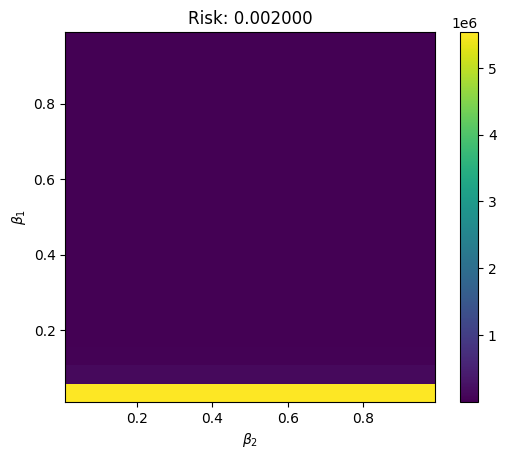

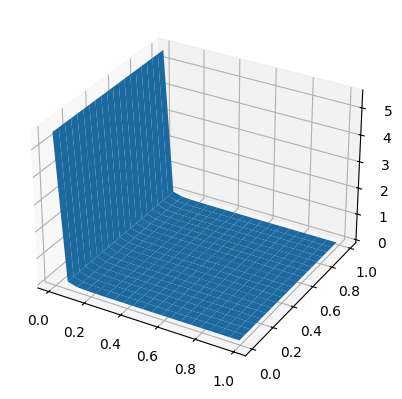

 33%|███▎      | 1/3 [00:22<00:44, 22.40s/it]

Risk: 1.000


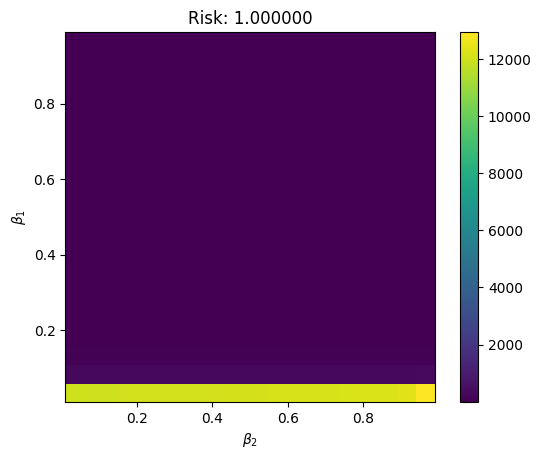

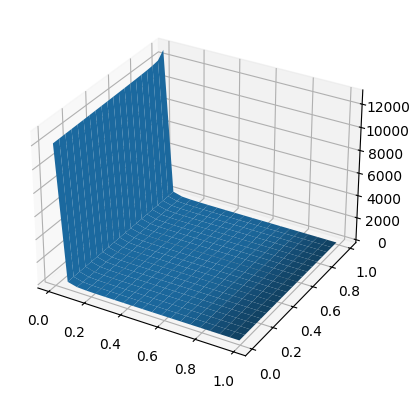

 67%|██████▋   | 2/3 [00:22<00:09,  9.34s/it]

Risk: 2.000


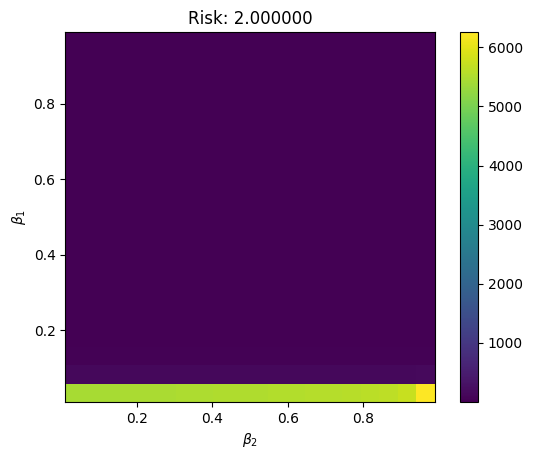

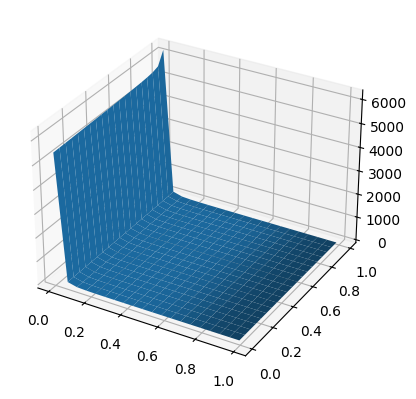

100%|██████████| 3/3 [00:22<00:00,  7.59s/it]


In [12]:
rhos = [0.999, 0.5, 0.0]

for rho in tqdm(rhos):
  B = jnp.array([[1, rho], [rho, 1]])

  risk = B[0,0] + B[1,1] - 2 * B[0,1]
  print(f"Risk: {risk:.3f}") # This is the risk of SGD in isotropic linear regression


  # in linear regression, phi[0] = - phi[1] so combine into one function and take only first element
  phi_vals = batch_phi_fn(B, beta1_flat, beta2_flat, eps, key)[:,0]
  cov_vals = batch_cov_fn(B, beta1_flat, beta2_flat, eps, key)[:,0,0]

  # save results
  phi_vals = jnp.array(phi_vals)
  cov_vals = jnp.array(cov_vals)
  jnp.savez(f'phi_cov_rho_{rho}_resolution1:{num}.npz', phi=phi_vals, cov=cov_vals)

  # similar to clip this ratio compares adam to sgd in isotropic linear regression (bigger is better)
  obj = phi_vals**2 / cov_vals
  obj_grid = obj.reshape(len(betas), len(betas))

  # Plotting
  fig, ax = plt.subplots()
  c = ax.imshow(obj_grid, extent= [mini,maxi,mini,maxi], origin='lower', cmap='viridis')
  ax.set_xlabel(r'$\beta_2$')
  ax.set_ylabel(r'$\beta_1$')
  ax.set_title(f'Risk: {risk:3f}')
  fig.colorbar(c, ax=ax)
  plt.show()

  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
  ax.plot_surface(beta1_grid, beta2_grid, obj_grid)
  plt.show()